In [92]:
import numpy as np
from numpy.fft import fftn, fftshift
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the data
data = np.load("subdata.npy")

# Task 1

Center Frequency Index: (39, 49, 10)
Center frequency: [ 5.34070751  2.19911486 -6.91150384]


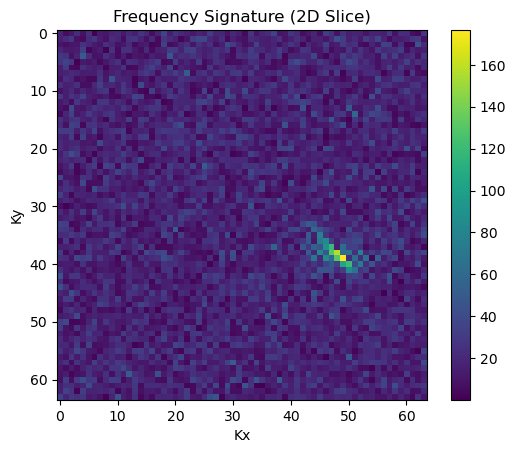

Center Frequency Index: (39, 49, 10)


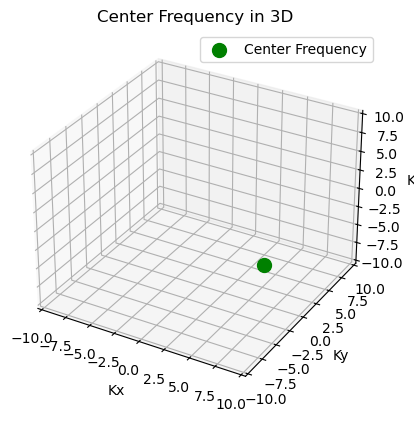

In [94]:
# Define spatial domain and Fourier modes
n = 64
L = 10
x2 = np.linspace(-L, L, n + 1)
x = x2[:-1]
y = x
z = x
k = (2 * np.pi / (2 * L)) * np.concatenate([np.arange(0, n // 2), np.arange(-n // 2, 0)])
ks = np.fft.fftshift(k)

X, Y, Z = np.meshgrid(x, y, z)
Kx, Ky, Kz = np.meshgrid(ks, ks, ks)

# Apply FFT and Average in Frequency Domain
sig_fourier_total = np.zeros((n, n, n), dtype=complex)
for t in range(49):
    sig = np.reshape(data[:, t], (n, n, n))
    sig_fourier = np.fft.fftn(sig)
    sig_fourier_shifted = np.fft.fftshift(sig_fourier)
    sig_fourier_total += sig_fourier_shifted

avg = np.abs(sig_fourier_total) / 49

# Identify Dominant Frequency
max_index = np.argmax(avg)
cent_freq_index = np.unravel_index(max_index, avg.shape)  # Get the index in the 3D grid
cent_freq = np.array([Kx.flatten(), Ky.flatten(), Kz.flatten()]).T[max_index]  # Maintain axis order
x_cf, y_cf, z_cf = cent_freq

# Print the index and the center frequency
print("Center Frequency Index:", cent_freq_index)
print("Center frequency:", cent_freq)

# Reshape data for visualization
data_reshaped = data.reshape((n, n, n, 49))
data_fft = fftshift(fftn(data_reshaped, axes=(0, 1, 2)))
frequency_signature = np.abs(np.average(data_fft, axis=3))
max_indices = np.unravel_index(np.argmax(frequency_signature), frequency_signature.shape)
center_frequency = max_indices

plt.figure()
plt.imshow(frequency_signature[:, :, center_frequency[2]], cmap='viridis')
plt.colorbar()
plt.xlabel('Kx')
plt.ylabel('Ky')
plt.title('Frequency Signature (2D Slice)')
plt.show()

print("Center Frequency Index:", center_frequency)

# Visualize the Center Frequency in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_cf, y_cf, z_cf, color='green', label='Center Frequency', s=100)  # Only center frequency
ax.set_title('Center Frequency in 3D')
ax.set_xlabel('Kx')
ax.set_ylabel('Ky')
ax.set_zlabel('Kz')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])
ax.legend()
plt.show()

# Task 2

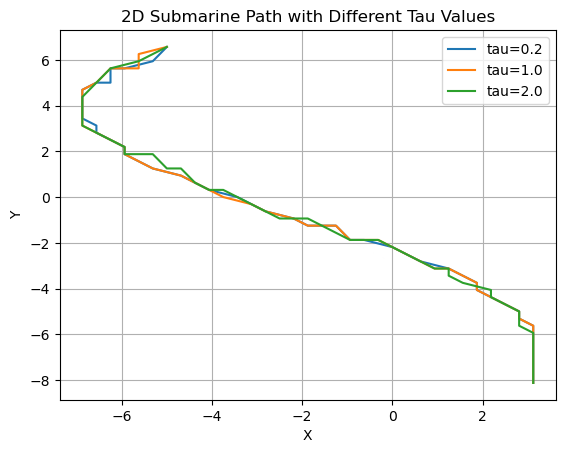

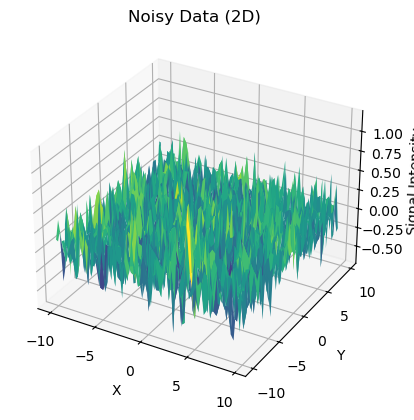

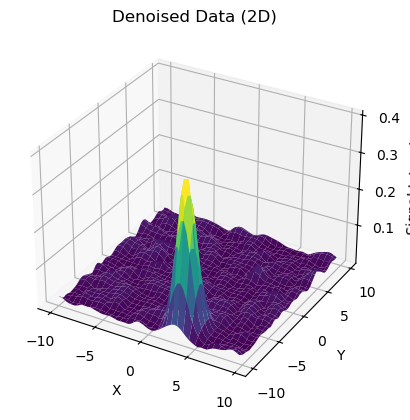

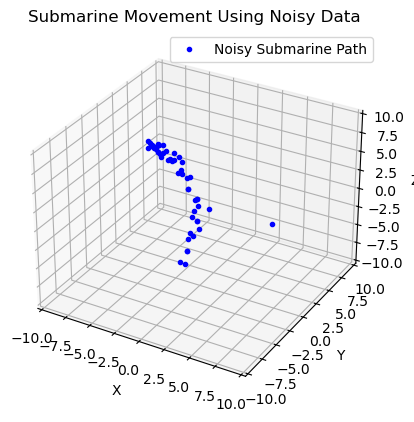

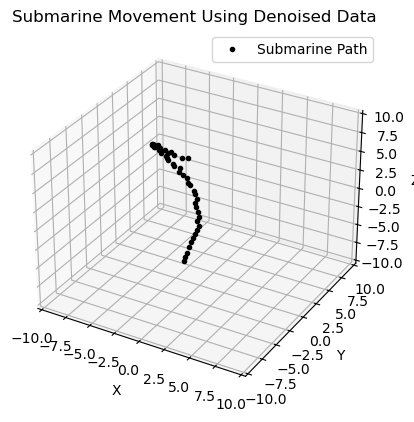

In [117]:
# Function to calculate submarine path with a specific tau
def calculate_submarine_path(data, tau):
    gauss_filter = np.exp(-tau * ((Kx - 5.34)**2 + (Ky - 2.20)**2 + (Kz + 6.91)**2))
    positions = np.zeros((49, 3))
    for t in range(49):
        sig = np.reshape(data[:, t], (n, n, n))
        filtered_sig = gauss_filter * np.fft.fftshift(np.fft.fftn(sig))
        spatial_sig = np.abs(np.fft.ifftn(np.fft.ifftshift(filtered_sig)))

        max_idx = np.unravel_index(np.argmax(spatial_sig), spatial_sig.shape)
        positions[t, :] = [X[max_idx], Y[max_idx], Z[max_idx]]
    return positions

# Calculate submarine paths for different tau values
taus = [0.2, 1.0, 2.0]
paths = {tau: calculate_submarine_path(data, tau) for tau in taus}

# Plot 2D paths for comparison
plt.figure()
for tau, path in paths.items():
    plt.plot(path[:, 0], path[:, 1], label=f"tau={tau}")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Submarine Path with Different Tau Values")
plt.legend()
plt.grid()
plt.show()

# Apply Gaussian Filter
a = 0.2
gauss_filter = np.exp(-a * ((Kx - x_cf)**2 + (Ky - y_cf)**2 + (Kz - z_cf)**2))

# Extract 2D slices for visualization
slice_idx = n // 2  # Middle slice
noisy_2d_slice = np.reshape(data[:, 0], (n, n, n))[:, :, slice_idx]  # First time slice
filtered_data = gauss_filter * np.fft.fftshift(np.fft.fftn(np.reshape(data[:, 0], (n, n, n))))
denoised_2d_slice = np.abs(np.fft.ifftn(np.fft.ifftshift(filtered_data)))[:, :, slice_idx]


# Plot Noisy Data (2D Slice)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X[:, :, slice_idx], Y[:, :, slice_idx], noisy_2d_slice, cmap='viridis')
ax.set_title('Noisy Data (2D)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Signal Intensity')
plt.show()

# Plot Denoised Data (2D Slice)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X[:, :, slice_idx], Y[:, :, slice_idx], denoised_2d_slice, cmap='viridis')
ax.set_title('Denoised Data (2D)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Signal Intensity')
plt.show()

# Calculate Submarine Path
positions = np.zeros((49, 3))
for t in range(49):
    sig = np.reshape(data[:, t], (n, n, n))
    filtered_sig = gauss_filter * np.fft.fftshift(np.fft.fftn(sig))
    spatial_sig = np.abs(np.fft.ifftn(np.fft.ifftshift(filtered_sig)))

    max_idx = np.unravel_index(np.argmax(spatial_sig), spatial_sig.shape)
    positions[t, :] = [np.real(X[max_idx]), np.real(Y[max_idx]), np.real(Z[max_idx])]

# Calculate Submarine Path using Noisy Data
noisy_positions = np.zeros((49, 3))
for t in range(49):
    sig = np.reshape(data[:, t], (n, n, n))  # Noisy data for time t
    max_idx = np.unravel_index(np.argmax(sig), sig.shape)  # Find the maximum intensity
    noisy_positions[t, :] = [X[max_idx], Y[max_idx], Z[max_idx]]  # Map to spatial coordinates

# Plot the path of the submarine using noisy data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(noisy_positions[:, 0], noisy_positions[:, 1], noisy_positions[:, 2], '.', color='blue', label='Noisy Submarine Path')
ax.set_xlim([-10, 10])  # Set X-axis limits
ax.set_ylim([-10, 10])  # Set Y-axis limits
ax.set_zlim([-10, 10])  # Set Z-axis limits
ax.set_title('Submarine Movement Using Noisy Data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()

# Plot the path of the submarine
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], '.', color='black', label='Submarine Path')
ax.set_xlim([-10, 10])  # Set X-axis limits
ax.set_ylim([-10, 10])  # Set Y-axis limits
ax.set_zlim([-10, 10])  # Set Z-axis limits
ax.set_title('Submarine Movement Using Denoised Data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()

# Task 3

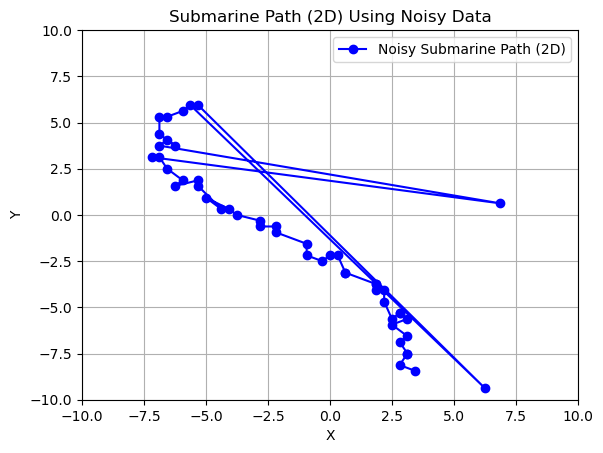

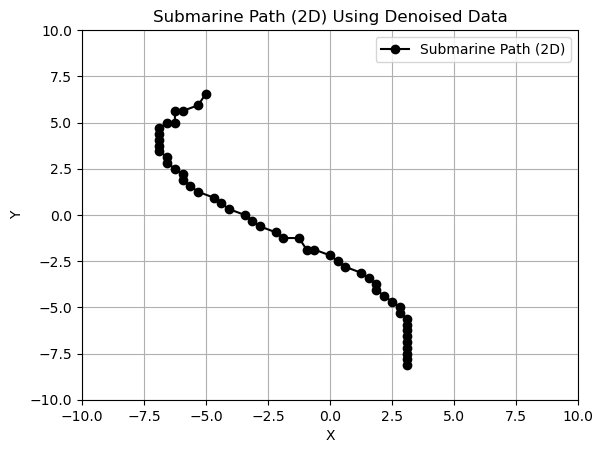

Final Position (X, Y, Z): [-5.      6.5625  0.9375]
Submarine Path Coordinates:
[[ 3.125  -8.125   0.    ]
 [ 3.125  -7.8125  0.3125]
 [ 3.125  -7.5     0.625 ]
 [ 3.125  -7.1875  1.25  ]
 [ 3.125  -6.875   1.5625]
 [ 3.125  -6.5625  1.875 ]
 [ 3.125  -6.25    2.1875]
 [ 3.125  -5.9375  2.5   ]
 [ 3.125  -5.625   2.8125]
 [ 2.8125 -5.3125  3.125 ]
 [ 2.8125 -5.      3.4375]
 [ 2.5    -4.6875  3.75  ]
 [ 2.1875 -4.375   4.0625]
 [ 1.875  -4.0625  4.375 ]
 [ 1.875  -3.75    4.6875]
 [ 1.5625 -3.4375  5.    ]
 [ 1.25   -3.125   5.    ]
 [ 0.625  -2.8125  5.3125]
 [ 0.3125 -2.5     5.3125]
 [ 0.     -2.1875  5.625 ]
 [-0.625  -1.875   5.625 ]
 [-0.9375 -1.875   5.9375]
 [-1.25   -1.25    5.9375]
 [-1.875  -1.25    5.9375]
 [-2.1875 -0.9375  5.9375]
 [-2.8125 -0.625   5.9375]
 [-3.125  -0.3125  5.9375]
 [-3.4375  0.      5.9375]
 [-4.0625  0.3125  5.9375]
 [-4.375   0.625   5.9375]
 [-4.6875  0.9375  5.625 ]
 [-5.3125  1.25    5.625 ]
 [-5.625   1.5625  5.3125]
 [-5.9375  1.875   5.3125]
 [

In [98]:
# Plot Submarine Path (2D Projection) using Noisy Data
plt.figure()
plt.plot(noisy_positions[:, 0], noisy_positions[:, 1], '-o', color='blue', label='Noisy Submarine Path (2D)')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.title('Submarine Path (2D) Using Noisy Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.show()

# Plot Submarine Path (2D Projection)
plt.figure()
plt.plot(positions[:, 0], positions[:, 1], '-o', color='black', label='Submarine Path (2D)')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.title('Submarine Path (2D) Using Denoised Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.show()

# Correct the final position manually for visualization
final_position = positions[-1, :]  # X, Y, Z
print("Final Position (X, Y, Z):", final_position)

print("Submarine Path Coordinates:")
print(positions)